In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

from data import PokemonDataset
from models import ConvNet, get_resnet18
from train_utils import train
from torchvision.models import resnet18

from utils import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

train_dataset = PokemonDataset(root='PokemonData', train=True, load_to_ram=True, transform=train_transform)
test_dataset = PokemonDataset(root='PokemonData', train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

## **Simple Convolutional Neural Networks**

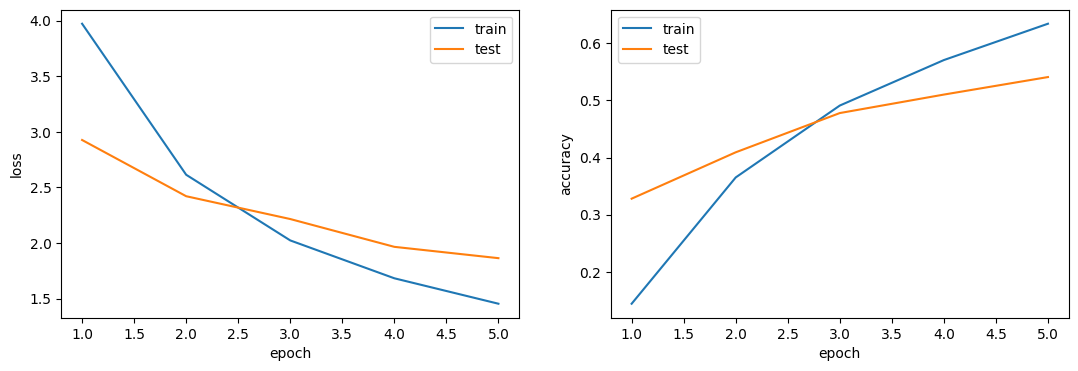

In [3]:
num_classes = len(train_dataset.classes)

model = ConvNet(num_classes=num_classes).to(device)
num_epochs = 15
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)



train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, device=device
)

In [5]:
print("final test accuracy:", test_accuracies[-1])

final test accuracy: 0.5408626560726447


## **ResNet**

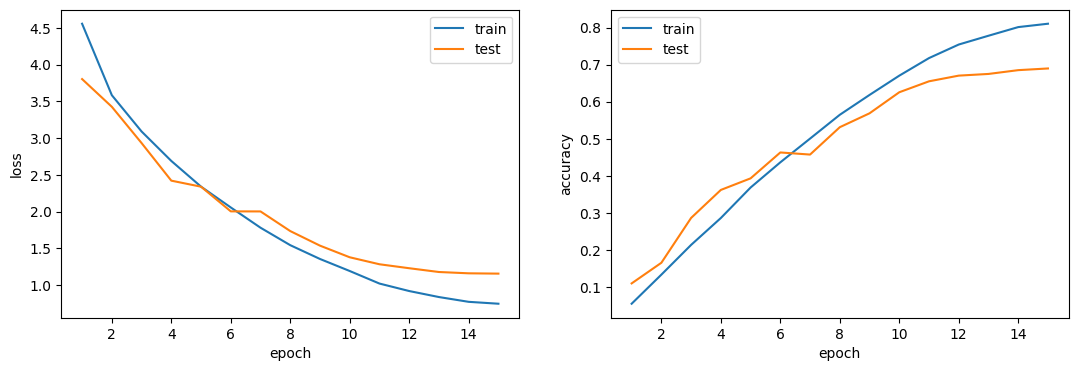

In [2]:
model2 = resnet18(num_classes=len(train_dataset.classes)).to(device)
num_epochs = 15
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model2, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, device=device
)

In [3]:
print("final test accuracy:", test_accuracies[-1])

final test accuracy: 0.6895573212258796


## **FIne-tuning ResNet**

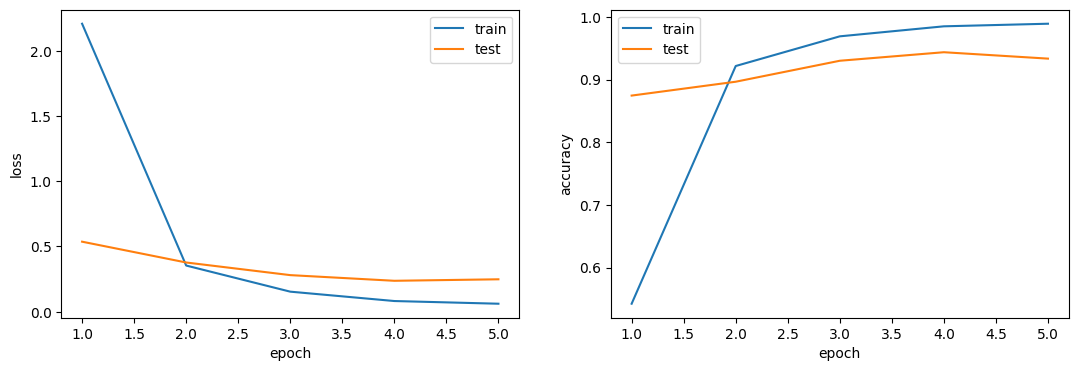

In [4]:
model = get_resnet18(num_classes=len(train_dataset.classes), pretrained=True).to(device)
num_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, device=device
)


In [7]:
print(f"Final test accuracy: {test_accuracies[-1]}")

Final test accuracy: 0.9335981838819524


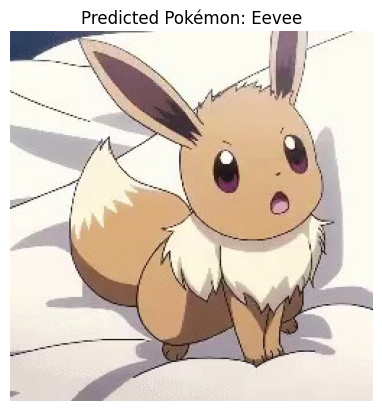

In [6]:
image_path = 'example_pokemon/9ee4e92b1c4a64f47e115ef5a241727a.jpg'

image_tensor = preprocess_image(image_path, test_transform)
predicted_class = predict_image(model, image_tensor, device)

class_names = train_dataset.classes

name = get_class_name(predicted_class, class_names)
show_predicted_pokemon_image(name, 'PokemonData')